In [1]:
from envs.edit_photo import PhotoEditor
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
with open('dataset/trainTarget.txt') as f :
    tif_images = f.read()
    jpg_images = tif_images.replace('tif','jpg')
with open('dataset/trainTarget_jpg.txt','w+') as f:
    f.write(jpg_images)
    
with open('dataset/trainSource.txt') as f :
    tif_images = f.read()
    jpg_images = tif_images.replace('tif','jpg')
with open('dataset/trainSource_jpg.txt','w+') as f:
    f.write(jpg_images)

In [3]:
image = cv2.imread("sample_images/a0676-kme_609_original.jpg")
target = cv2.imread("sample_images/a0676-kme_609_C.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255.0
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)/255.0
photo_editor = PhotoEditor()
parameters = np.array([0.125, 0.125, 0.375, 0.125, 0., 0.0625, 0.9375, 0.375, 0.0625, 0., 0.125, 0.125])

In [4]:
image.shape

(512, 340, 3)

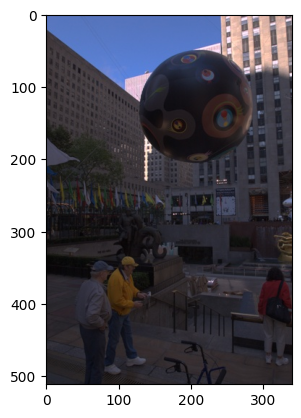

In [5]:
plt.imshow(image)

In [6]:
# from PIL import Image

# def resize_length(image_array, size=512):
#     """
#     Resize the longer side of the image to the specified size while maintaining the aspect ratio.

#     :param image_array: NumPy array representing the image.
#     :param size: The target size for the longer side of the image.
#     :return: Resized image as a NumPy array.
#     """
#     image = Image.fromarray(image_array)
#     original_width, original_height = image.size
#     if original_width > original_height:
#         new_width = size
#         new_height = int((original_height / original_width) * size)
#     else:
#         new_height = size
#         new_width = int((original_width / original_height) * size)
#     resized_image = image.resize((new_width, new_height), Image.LANCZOS)
#     resized_image_array = np.array(resized_image)
    
#     return resized_image_array

In [7]:
# input = resize_length(image)
# input = input / 255.0

In [9]:
output = photo_editor(image.copy(),parameters.copy())

(512, 340, 3)
(512, 340, 3)


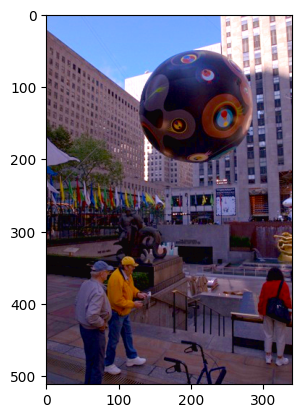

In [10]:
plt.imshow(output)

In [44]:
import torch
enhanced = torch.Tensor(output)
enhanced_target = torch.Tensor(target)
enhanced =torch.flatten(enhanced.clone(),start_dim=0, end_dim=-1)
enhanced_target = torch.flatten(enhanced_target.clone(),start_dim=0, end_dim=-1)
t= enhanced_target.clone()
t[0]=0
rmse =  enhanced-enhanced_target
rmse = torch.pow(rmse,2).mean()
rmse = torch.sqrt(rmse)

rewards = -rmse
psnr = 20 * torch.log10(1/ rmse) 
psnr = psnr -100
psnr

tensor(-74.1229)

In [49]:
torch.Tensor([True,False]).all()

tensor(False)

In [10]:
import torch
from torchrl.data import TensorDictReplayBuffer,LazyMemmapStorage
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from tensordict import TensorDict
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define buffer parameters
buffer_size = 9000  # example buffer size

# Initialize the replay buffer on the GPU
replay_buffer = TensorDictReplayBuffer(
                        storage=LazyMemmapStorage(buffer_size,), sampler=SamplerWithoutReplacement()
                                                        )

# Populate the buffer with sample data
# Example of how to add data to the buffer
for _ in range(buffer_size):
    # Create a sample data point
    state = torch.randn((32,512,), device=device)  # Replace state_size with actual size
    action = torch.randn((32,15,), device=device).clamp(-1, 1)  # 15-dimensional continuous action
    reward = torch.randn(32, device=device)
    next_state = torch.randn((32,512,), device=device)  # Replace state_size with actual size
    done = torch.randn(32, device=device)  # Example done flag
    batch_transition = TensorDict(
            {
                "observations":state.clone(),
                "next_observations":next_state.clone(),
                "actions":action.clone(),
                "rewards":reward.clone(),
                "dones":done.clone(),
            },
            batch_size = 32,
        )
    # Add to the replay buffer
    replay_buffer.add(batch_transition)

# Verify buffer storage on GPU
sample = replay_buffer.sample(1)  # Sample a single transition
print(sample['state'].device)  # Should output: cuda:0
print(sample['action'].device)  # Should output: cuda:0
print(sample['reward'].device)  # Should output: cuda:0
print(sample['next_state'].device)  # Should output: cuda:0
print(sample['done'].device)  #

KeyError: 'key "state" not found in TensorDict with keys [\'actions\', \'dones\', \'index\', \'next_observations\', \'observations\', \'rewards\']'

In [21]:
from torcheval.metrics import PeakSignalNoiseRatio
metric = PeakSignalNoiseRatio()
metric.update(enhanced.permute(2,0,1), enhanced_target.permute(2,0,1))
metric.compute()

tensor(25.8771)